In [1]:
import numpy as np
from sklearnex import patch_sklearn, config_context
patch_sklearn()

# from sklearn.cluster import DBSCAN

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
from daal4py.sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import collections
from scipy.stats import pearsonr
from daal4py.sklearn.model_selection import _daal_train_test_split as train_test_split
import seaborn as sns
from daal4py.sklearn.manifold import TSNE
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

The dataset we have used is the ethereum fraud detection dataset from Kaggle. The link to the dataset is https://www.kaggle.com/datasets/vagifa/ethereum-frauddetection-dataset

In [3]:
raw_dataset = pd.read_csv('C:/Users/aarya/Downloads/archive/transaction_dataset.csv')
raw_dataset

,Unnamed: 0,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,None,XENON
3,3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9836,9836,2175,0xff481ca14e6c16b79fc8ab299b4d2387ec8ecdd2,1,12635.10,631.39,58748.48,4,13,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,2.0,,GSENetwork
9837,9837,2176,0xff718805bb9199ebf024ab6acd333e603ad77c85,1,0.00,0.00,0.00,0,0,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,1.0,,Blockwell say NOTSAFU
9838,9838,2177,0xff8e6af02d41a576a0c82f7835535193e1a6bccc,1,2499.44,2189.29,261601.88,67,43,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,5.0,,Free BOB Tokens - BobsRepair.com
9839,9839,2178,0xffde23396d57e10abf58bd929bb1e856c7718218,1,0.00,0.00,0.00,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



The datset conatains 51 columns out of which we have seleted 11 columns on which we will perform the training and testing of our model.

Description of the dataset-
1. Address: the address of the ethereum account
2. Avg_Val_Sent: Average value of Ether ever sent
3. Sent_tnx: Total number of sent normal transactions
4. Avg min between sent tnx: Average time between sent transactions for account in minutes
5. Max_Val_Sent: Maximum value of Ether ever sent
6. Avg_Value_Received: Average value in Ether ever received
7. Received_tnx: Total number of received normal transactions
8. Avg_min_between_received_tnx: Average time between received transactions for account in minutes
9. Max_Value_Received: Maximum value in Ether ever received
10. Total_Transactions(Including_Tnx_to_Create_Contract): Total number of transactions
11. FLAG: whether the transaction is fraud or not

In [4]:
df_toUse = raw_dataset[["Address", "avg val sent", "Sent tnx", "Avg min between sent tnx", "max val sent", "avg val received", "Received Tnx", "Avg min between received tnx", "max value received ", "total transactions (including tnx to create contract", "FLAG"]]
df_toUse

,Address,avg val sent,Sent tnx,Avg min between sent tnx,max val sent,avg val received,Received Tnx,Avg min between received tnx,max value received,total transactions (including tnx to create contract,FLAG
0,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,1.200681,721,844.26,31.220000,6.589513,89,1093.71,45.806785,810,0
1,0x0002b44ddb1476db43c868bd494422ee4c136fed,0.032844,94,12709.07,1.800000,0.385685,8,2958.44,2.613269,102,0
2,0x0002bda54cb772d040f779e88eb453cac0daa244,1.794308,2,246194.54,3.538616,0.358906,10,2434.02,1.165453,12,0
3,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,70.001834,25,10219.60,450.000000,99.488840,9,15785.09,500.000000,34,0
4,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0.022688,4598,36.61,9.000000,2.671095,20,10707.77,12.802411,4619,0
...,...,...,...,...,...,...,...,...,...,...,...
9836,0xff481ca14e6c16b79fc8ab299b4d2387ec8ecdd2,9.166365,4,12635.10,12.200000,2.821060,13,631.39,12.000000,17,1
9837,0xff718805bb9199ebf024ab6acd333e603ad77c85,0.000000,0,0.00,0.000000,0.000000,0,0.00,0.000000,0,1
9838,0xff8e6af02d41a576a0c82f7835535193e1a6bccc,0.922179,67,2499.44,9.500000,1.234192,43,2189.29,21.310000,110,1
9839,0xffde23396d57e10abf58bd929bb1e856c7718218,0.000000,0,0.00,0.000000,0.500000,1,0.00,0.500000,1,1


In this step we are normalizing the data to come to a particular range for all the datasets.This will help further in training and testing the dataset

In [5]:
temp = df_toUse.drop(['Address','FLAG'], axis = 1)
trans = PowerTransformer()
trans_train_f = trans.fit_transform(temp)
trans_df = pd.DataFrame(trans_train_f, columns=temp.columns)
trans_df

,avg val sent,Sent tnx,Avg min between sent tnx,max val sent,avg val received,Received Tnx,Avg min between received tnx,max value received,total transactions (including tnx to create contract
0,-0.345094,1.902089,0.996239,0.721941,0.466701,1.289354,0.463574,0.820605,1.700603
1,-1.101082,1.533728,1.463276,-0.495125,-0.906854,0.223306,0.717357,-0.469944,1.061163
2,-0.144595,-0.211835,1.826552,-0.206546,-0.928037,0.348591,0.667180,-0.814859,0.042637
3,1.425104,1.112440,1.431088,1.524905,1.447404,0.290037,1.156298,1.556920,0.588796
4,-1.112322,2.069363,0.233867,0.210693,-0.018784,0.704083,1.053220,0.285223,2.051991
...,...,...,...,...,...,...,...,...,...
9836,0.694730,0.199264,1.462425,0.342746,0.011433,0.489397,0.325721,0.255531,0.235601
9837,-1.137983,-1.397246,-1.101747,-1.208791,-1.281370,-1.787476,-1.184594,-1.405346,-2.087454
9838,-0.466242,1.442971,1.201561,0.234420,-0.432361,1.033705,0.640015,0.511110,1.089863
9839,-1.137983,-1.397246,-1.101747,-1.208791,-0.822327,-1.003561,-1.184594,-1.084361,-1.386667


In [13]:
trans_df['labels'] = df_toUse['FLAG']
num_clusters = range(1, 20)
trans_df_temp = trans_df.drop(['labels'], axis = 1)
trans_df_temp.head()

,avg val sent,Sent tnx,Avg min between sent tnx,max val sent,avg val received,Received Tnx,Avg min between received tnx,max value received,total transactions (including tnx to create contract
0,-0.345094,1.902089,0.996239,0.721941,0.466701,1.289354,0.463574,0.820605,1.700603
1,-1.101082,1.533728,1.463276,-0.495125,-0.906854,0.223306,0.717357,-0.469944,1.061163
2,-0.144595,-0.211835,1.826552,-0.206546,-0.928037,0.348591,0.667180,-0.814859,0.042637
3,1.425104,1.112440,1.431088,1.524905,1.447404,0.290037,1.156298,1.556920,0.588796
4,-1.112322,2.069363,0.233867,0.210693,-0.018784,0.704083,1.053220,0.285223,2.051991


In this step we are plotting the elbow graph to find out the optimal value for clusters

C:\Users\aarya\anaconda3\envs\thappa\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\aarya\anaconda3\envs\thappa\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\aarya\anaconda3\envs\thappa\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\aarya\anaconda3\envs\thappa\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users

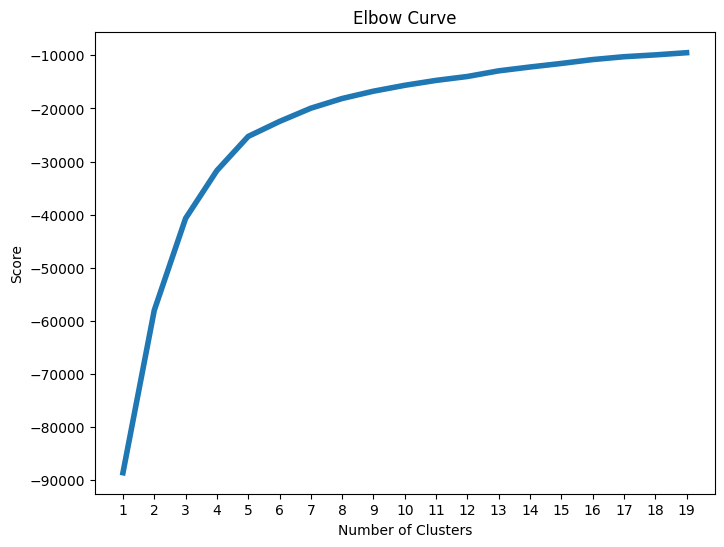

In [14]:
with config_context(target_offload="gpu:0"):
    kmeans = [KMeans(n_clusters=i, random_state=42).fit(trans_df_temp) for i in num_clusters]
    scores = [kmeans[i].score(trans_df_temp) for i in range(len(kmeans))]

    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(num_clusters, scores, linewidth = 4)
    plt.xticks(num_clusters)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Elbow Curve')
    plt.show();

In [15]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(trans_df_temp)

C:\Users\aarya\anaconda3\envs\thappa\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2)

In [18]:
# Generating t-SNE for the dataset to plot the high dimension graph for visualisation
temp_data_new = df_toUse.drop(['Address','FLAG'], axis = 1)


[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 9841 samples in 0.013s...
[t-SNE] Computed neighbors for 9841 samples in 0.526s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9841
[t-SNE] Computed conditional probabilities for sample 2000 / 9841
[t-SNE] Computed conditional probabilities for sample 3000 / 9841
[t-SNE] Computed conditional probabilities for sample 4000 / 9841
[t-SNE] Computed conditional probabilities for sample 5000 / 9841
[t-SNE] Computed conditional probabilities for sample 6000 / 9841
[t-SNE] Computed conditional probabilities for sample 7000 / 9841
[t-SNE] Computed conditional probabilities for sample 8000 / 9841
[t-SNE] Computed conditional probabilities for sample 9000 / 9841
[t-SNE] Computed conditional probabilities for sample 9841 / 9841
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.651489
[t-SNE] KL divergence after 1000 iterations: 0.794328


C:\Users\aarya\AppData\Local\Temp\ipykernel_12112\1988515299.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tsne-2d-one'] = tsne_results[:,0]
C:\Users\aarya\AppData\Local\Temp\ipykernel_12112\1988515299.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tsne-2d-two'] = tsne_results[:,1]


<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

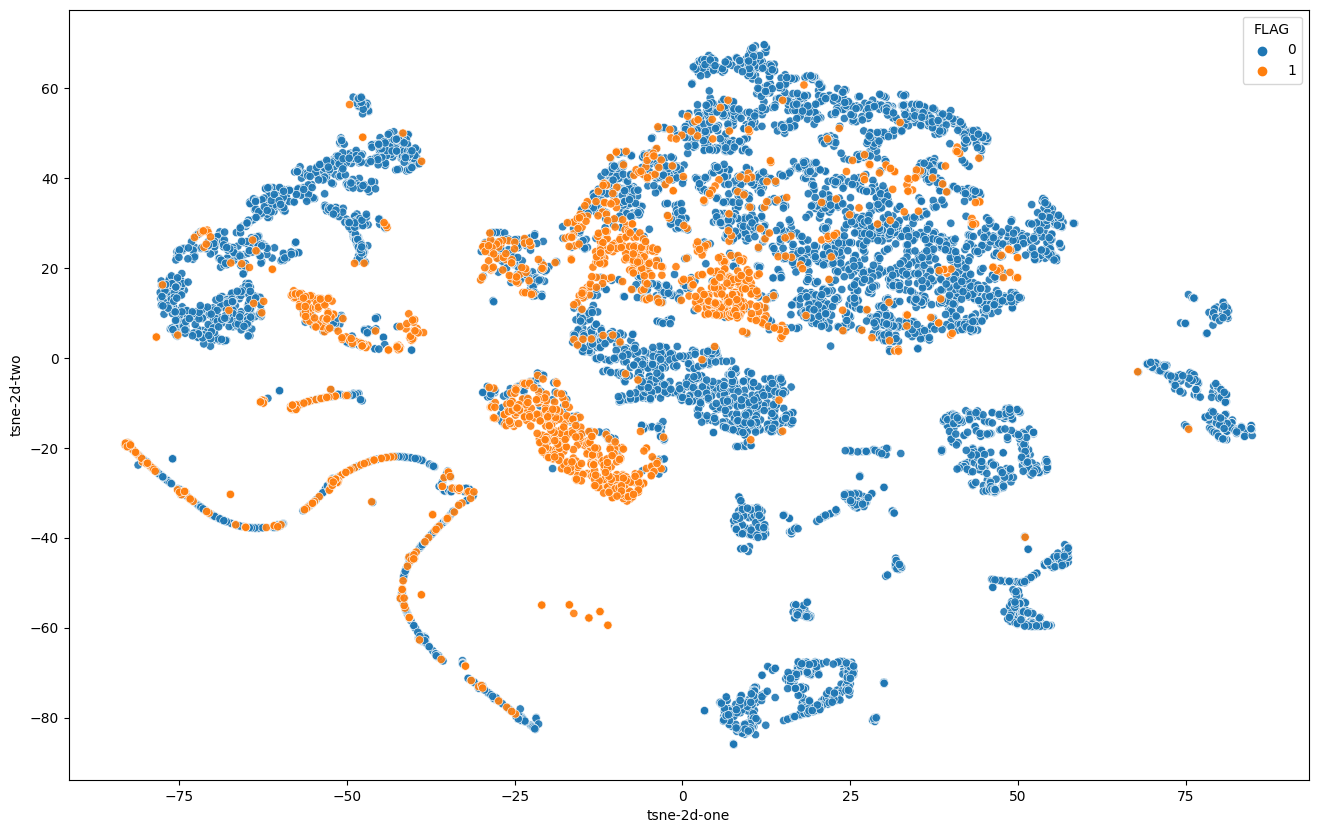

In [31]:
#Generating a TSNE to validate the data
tsne = TSNE(n_components=2, verbose=1, perplexity=45)
tsne_results = tsne.fit_transform(trans_df_temp)
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="FLAG",
    data= df,
    legend="full",
    alpha=0.9
)

In [52]:
#Training a model 
# Split the data into x_train and y_train data sets
y = df['FLAG']
X = df.drop(['Address','FLAG', 'tsne-2d-one','tsne-2d-two'], axis = 1)
x_training, x_testing, y_training, y_testing = train_test_split(X, y, train_size=0.8, random_state=0)

In [53]:
# Training the model
clf = RandomForestClassifier()
clf.fit(x_training, y_training)
y_pred = clf.predict(x_testing)

# Generating classification report
print(classification_report(y_testing, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1504
           1       0.86      0.77      0.81       465

    accuracy                           0.92      1969
   macro avg       0.90      0.87      0.88      1969
weighted avg       0.91      0.92      0.91      1969

